In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import CCM as cfn
import LCE as lfn

# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/Data2process/Project/' 
F10t2 = '/Volumes/Dominic 10tb2/Data2process/Project/'
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/domiHRnicburrows/Dropbox/PhD/figures/'

%load_ext autoreload
sys.version

ImportError: No module named 'admin_functions'

In [2]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions_salk as adfn
import CCM as cfn
import LCE as lfn
# Define paths

#----------------------------------------------------------------------
Fcode = '/nadata/mnlsc/home/dburrows/Documents/empirical_dynamic_modelling/'
Fdata = '/scratch/dburrows/PTZ-WILDTYPE-CCM/single/'
#Fdata = '/mnlsc/data/MCBL4/dburrows/single/'

%load_ext autoreload
sys.version

'3.5.3 (default, Nov  4 2021, 15:29:10) \n[GCC 6.3.0 20170516]'

# Visualise Lorenz

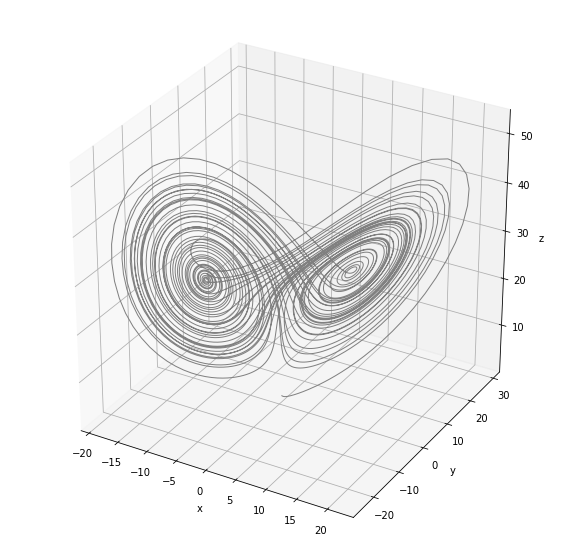

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dt = 0.01
steps = 5000
sigma = 10
r = 28
b = 2.667
xs = np.empty(steps + 1)
ys = np.empty(steps + 1)
zs = np.empty(steps + 1)

# Set starting values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Calculate the partial derivatives at each t, then estimate t+1
for i in range(steps):
    x_d, y_d, z_d = lfn.Lorenz(xs[i], ys[i], zs[i], sigma, r, b)
    xs[i + 1] = xs[i] + (x_d * dt)
    ys[i + 1] = ys[i] + (y_d * dt)
    zs[i + 1] = zs[i] + (z_d * dt)


# Visualise
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs, lw=1, c = 'grey')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

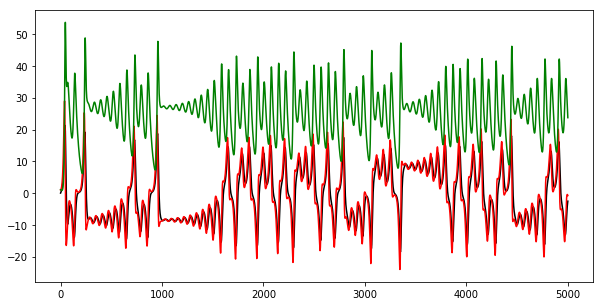

In [4]:
fig = plt.figure(figsize=(10,5))
plt.plot(xs, c = 'k')
plt.plot(ys, c = 'red')
plt.plot(zs, c = 'green')

# Simplex projection

In [252]:
#Check relationship between rhodiff/rho/E and SNR 
tr_l = adfn.return_files(Fdata, '', '*BLN_r*CCM.npy*')
xmap_l = adfn.return_files(Fdata, '', '*BLN_r*xmap*')
tr_l[0], xmap_l[0]

('PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_pre-CCM.npy',
 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_trace_CCMxmap.h5')

In [253]:
tr = np.load(tr_l[0], allow_pickle=True).item()['trace']
import h5py
xmap = h5py.File(xmap_l[0])
e = np.array(xmap['e'])[1:]

In [254]:
tr.shape, e.shape

((11038, 9828), (11038,))

In [255]:
e

array([12, 15,  9, ...,  1, 20,  8], dtype=int32)

In [256]:
tr[0]

array([1101.0016  ,  375.2699  ,  160.53424 , ...,  563.22595 ,
        127.223816,  208.07672 ], dtype=float32)

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
E = 2


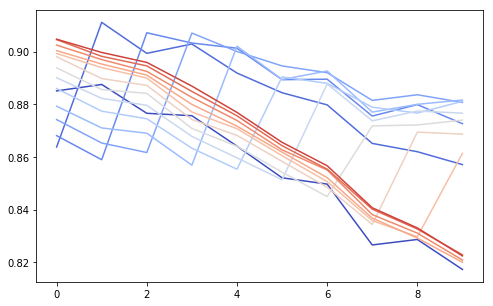

In [260]:
#Find the correct embedding dimension - E
#Which embedding unfolds the manifold to give the greatest accuracy prediction? 

data = tr[0]
tau = 1
t_range = 10
E_range = 15

corr_l = [0]*E_range
for E in range(1, E_range+1):
    corr_l[E-1] = cfn.simplex_project(data, E, tau, t_range)
    print('Done ' + str(E))
    
from matplotlib import cm
cmap = cm.coolwarm(np.linspace(0,1,E_range))
fig = plt.figure(figsize = (8,5))
for x in range(E_range-1):
    plt.plot(corr_l[x], c = cmap[x])

E = np.where(corr_l == np.max(corr_l))[0][0] + 1
print('E = ' + str(E))

Tau = 15


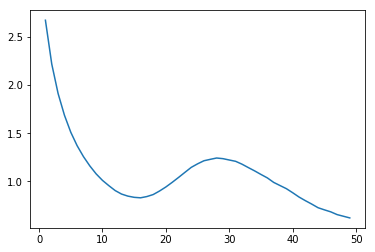

In [218]:
# Find tau - time delays that are maximally independent - how can we provide max information for each dimension?
from scipy.signal import argrelextrema

data = xs

MI_list = []
tau_range = 50
for i in range(1,tau_range):
    MI_list = np.append(MI_list,[lfn.MI(data,i,50)])
plt.plot(range(1,tau_range), MI_list)

tau = argrelextrema(MI_list, np.less)[0][0] #find the first minima of MI function
print('Tau = ' + str(tau))

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
E = 0


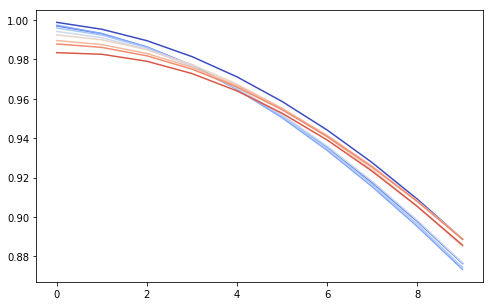

In [226]:
#Find the correct embedding dimension - E
#Which embedding unfolds the manifold to give the greatest accuracy prediction? 

t_range = 10
E_range = 10

corr_l = [0]*E_range
for E in range(1, E_range+1):
    corr_l[E-1] = cfn.simplex_project(data, E, tau, t_range)
    print('Done ' + str(E))
    
from matplotlib import cm
cmap = cm.coolwarm(np.linspace(0,1,E_range))
fig = plt.figure(figsize = (8,5))
for x in range(E_range-1):
    plt.plot(corr_l[x], c = cmap[x])

E = np.where(corr_l == np.max(corr_l))[0][0] + 1
print('E = ' + str(E))

In [246]:
tau = lfn.find_tau(data)
tau

15

In [238]:
cfn.find_E_simplex(data, tau, E_range, t_range)

Done E = 1
Done E = 2
Done E = 3
Done E = 4
Done E = 5
Done E = 6
Done E = 7
Done E = 8
Done E = 9
Done E = 10


1

In [ ]:
lfn.find_E_FNN(data, 15, 10)

In [262]:
data = xs
tau = 15
t_range = 10
E = 3

In [263]:
from scipy import spatial
import numpy as np

corr_list = cfn.list_series(2, t_range) # for each time prediction there should be a 2d list to put in real and pred values


# split data in half into library and prediction
lib = data[:data.shape[0]//2]
pred = data[data.shape[0]//2:]

# Build manifold with given E and tau
lib_m = lfn.takens_embed(E, tau, lib)
pred_m = lfn.takens_embed(E, tau, pred)

#find the E+1 nearest neighbours in library
dist_mat = spatial.distance_matrix(pred_m, lib_m) #compute distances between all points
nn_num = E+1 #how many nearest neighbours to find


#Loop through each point in pred
for num in range(pred_m.shape[0]):

    # Find nearest neighbours in library for each pred_m point
    current_point = pred_m[num]
    curr_dist = dist_mat[num]
    nn_ind = sorted(range(len(curr_dist)), key=lambda k: curr_dist[k])[:nn_num] #return indeces of nearest neighbours in library

    #Calculate weights for simplex projection - weights are calculated from nn distance at t0
    nn = lib_m[nn_ind] #positions of nearest neighbours in library, to current point in pred at t0
    nn_dist = dist_mat[num, nn_ind]  #distances of each nn to our pred point
    w_mat = np.exp(-1*(nn_dist/np.min(nn_dist))) #matrix of weights for each nn 

    # Loop in time and predict
    for t in range(t_range):

        # Where do nn end up at t + n
        nn_ind_tp = np.array(nn_ind) + t #find indeces of neighbours in the future for simplex projection

        if sum(nn_ind_tp >= lib_m.shape[0]) >0: #ignore points whose boundaries go outside the data 
            continue 

        nn_tp = lib_m[nn_ind_tp] # locations of neighbours in future

        #Simple project - how much do the positions of neighbours relative to point of interest change over time 
        #use weights from t 0
        #use neighbour points from t + n
        x_tp = pred[num] #Point I am trying to predict

        x_tp_pred = 0 
        for nn_i in range(w_mat.shape[0]): #Loop through each nn and sum over the weight*position at tp
            x_tp_pred+= (w_mat[nn_i]/np.sum(w_mat))*nn_tp[nn_i]
        x_tp_pred = x_tp_pred[0] #project back into 1d space

        corr_list[t][0] = np.append(corr_list[t][0], x_tp) #true
        corr_list[t][1] = np.append(corr_list[t][1], x_tp_pred) #estimated

    #Calculate correlation coefficient
    corr_vec = []
    for f in range(len(corr_list)): corr_vec = np.append(corr_vec, np.corrcoef(corr_list[f][0][1:],corr_list[f][1][1:])[0][1])

In [290]:
corr_vec

array([0.99866528, 0.997334  , 0.99318723, 0.98629396, 0.97675836,
       0.96471658, 0.9503315 , 0.9337903 , 0.91530221, 0.89508807])

In [266]:
current_point

array([ -6.59262556, -12.35027002,  -9.29093656])

In [269]:
curr_dist[nn_ind]

array([0.30738581, 0.66152068, 0.71276749, 0.72470343])

In [268]:
nn_ind

[1490, 115, 838, 1489]

In [281]:
#Calculate weights for simplex projection - weights are calculated from nn distance at t0
nn_tp
nn = lib_m[nn_ind] #positions of nearest neighbours in library, to current point in pred at t0
nn_dist = dist_mat[num, nn_ind]  #distances of each nn to our pred point
w_mat = np.exp(-1*(nn_dist/np.min(nn_dist))) #matrix of weights for each nn 

In [282]:
w_mat

array([0.36787944, 0.11624144, 0.09839118, 0.09464383])

In [283]:
nn, nn_dist

(array([[ -6.82760758, -12.15548963,  -9.25446614],
        [ -6.30527582, -12.94343055,  -9.23436519],
        [ -6.12258953, -12.77800957,  -9.61364774],
        [ -6.54832655, -11.86128122,  -9.82396809]]),
 array([0.30738581, 0.66152068, 0.71276749, 0.72470343]))

In [284]:
t

9

In [285]:
nn_ind

[1490, 115, 838, 1489]

In [288]:
nn_ind_tp = np.array(nn_ind) + t
nn_ind_tp

array([1499,  124,  847, 1498])

In [289]:
sum(nn_ind_tp >= lib_m.shape[0])

0

In [279]:
# Where do nn end up at t + n
nn_ind_tp = np.array(nn_ind) + t #find indeces of neighbours in the future for simplex projection

if sum(nn_ind_tp >= lib_m.shape[0]) >0: #ignore points whose boundaries nn_tpnn_tpnn_tpgo outside the data 
    continue 

nn_tp = lib_m[nn_ind_tp] # locations of neighbours in future

#Simple project - how much do the positions of neighbours relative to point of interest change over time 
#use weights from t 0
#use neighbour points from t + n
x_tp = pred[num] #Point I am trying to predict

x_tp_pred = 0 
for nn_i in range(w_mat.shape[0]): #Loop through each nn and sum over the weight*position at tp
    x_tp_pred+= (w_mat[nn_i]/np.sum(w_mat))*nn_tp[nn_i]
x_tp_pred = x_tp_pred[0] #project back into 1d space

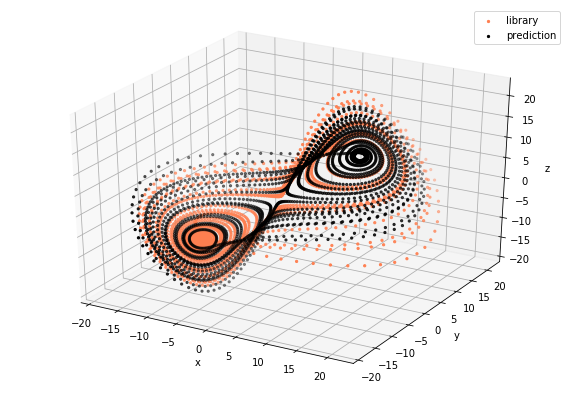

In [251]:
#Visualise library and prediction
data = xs
E = 3
tau = 10
nn_tp
lib = data[:data.shape[0]//2]
pred = data[data.shape[0]//2:]

# Build manifold with given E and tau
lib_m = lfn.takens_embed(E, tau, lib)
pred_m = lfn.takens_embed(E, tau, pred)

#Visualise 
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(lib_m[:,0],lib_m[:,1], lib_m[:,2], s=5, c = 'coral', label = 'library')
ax.scatter3D(pred_m[:,0],pred_m[:,1], pred_m[:,2], s=5, c = 'k', label = 'prediction')

ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

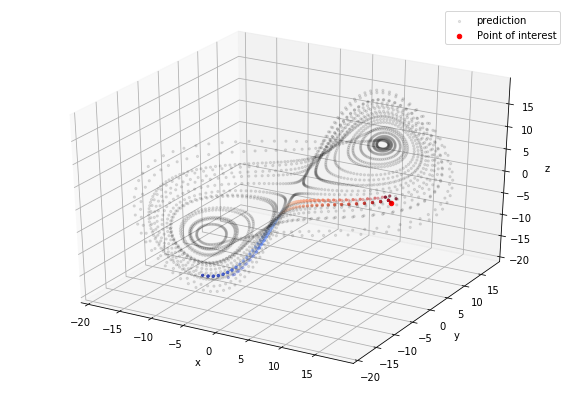

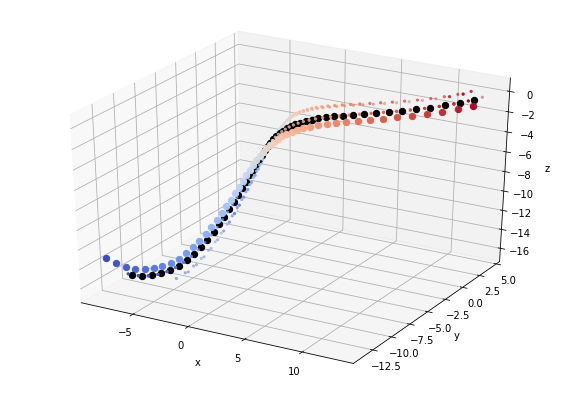

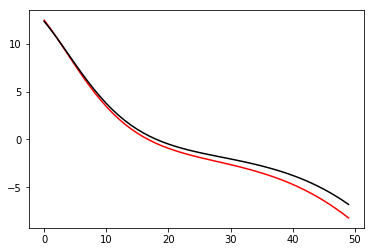

In [171]:
#Visualise prediction point and library neighbours over time

num = 0
t_range = 30

#find the E+1 nearest neighbours in library
dist_mat = scipy.spatial.distance_matrix(pred_m, lib_m) #compute distances between all points
nn_num = E+1 #how many nearest neighbours to find
# Find nearest neighbours in library for each pred_m point
current_point = pred_m[num]
curr_dist = dist_mat[num]
nn_ind = sorted(range(len(curr_dist)), key=lambda k: curr_dist[k])[:nn_num] #return indeces of nearest neighbours in library
nn = lib_m[nn_ind] #positions of nearest neighbours in library, to current point in pred

from matplotlib import cm
colormap = cm.coolwarm_r(np.linspace(0, 1, t_range))

#Show nearest neighbours over time
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(pred_m[:,0],pred_m[:,1], pred_m[:,2], s=5, c = 'k', label = 'prediction', alpha = 0.1)
ax.scatter3D(current_point[0],current_point[1], current_point[2], s=20, c = 'red', label = 'Point of interest')
ax.scatter3D(nn[:,0],nn[:,1],nn[:,2], s=5, c = 'k')

# Loop in time and predict
for t in range(t_range):
    # Where do nn end up at t + n
    nn_ind_tp = np.array(nn_ind) + t #find indeces of neighbours in the future for simplex projection
    nn_tp = lib_m[nn_ind_tp] # locations of neighbours in future
    ax.scatter3D(nn_tp[:,0],nn_tp[:,1],nn_tp[:,2], s=5, c = np.expand_dims(colormap[t], 0))

ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

est_list = []

#Compare reconstructed with true
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111, projection='3d')

# Loop in time and predict
for t in range(t_range):
    # Where do nn end up at t + n
    nn_ind_tp = np.array(nn_ind) + t #find indeces of neighbours in the future for simplex projection
    nn_tp = lib_m[nn_ind_tp] # locations of neighbours in future
    ax.scatter3D(nn_tp[:,0],nn_tp[:,1],nn_tp[:,2], s=5, c = np.expand_dims(colormap[t], 0))
    
    x_tp = pred[num] #Point I am trying to predict
    x_tp_pred = 0
    for nn_i in range(w_mat.shape[0]): #Loop through each nn and sum over the weight*position at tp
        x_tp_pred+= (w_mat[nn_i]/np.sum(w_mat))*nn_tp[nn_i]
        
    true = pred_m[num + t]
    ax.scatter3D(true[0],true[1],true[2], s=40, c = np.expand_dims(colormap[t], 0)) #Plot the true point
    ax.scatter3D(x_tp_pred[0],x_tp_pred[1],x_tp_pred[2], s=40, c = 'k') #plot the predicted point
    est_list = np.append(est_list, x_tp_pred[0])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

plt.plot(pred[:t_range], c = 'red')
plt.plot(est_list, c = 'k')
plt.show()

# Convergent Cross Mapping

In [ ]:
#Does X cause Y?
#Can we use Y to reconstruct X?

cause = xs #the variable being tested as a causal factor
effect = ys #the variable being influenced by the cause


In [ ]:
#Show CCM convergence as you increase more of the data

In [ ]:
#===============================
def CCM_project(cause, effect, E, tau, t_range):
#===============================

    """
    This function performs CCM over t time steps. Briefly, it splits a time series in library and prediction sets.
    It then embeds the library manifold in E dimensions, using E time lags. For each point p (embedded in E dim space) in the 
    prediction timeseries, the algorithm finds the E+1 nearest neighbours in the library manifold which forms a simplex around 
    the point p. The algorithm then iterates t time steps into the future, predicting the position of point p at t using the 
    positions of each neighbour at t exponentially weighted by the distances from p at t0. Finally the correlation between true
    and predicted values are returned. See: Sugihara et al. 'Nonlinear Forecasting as a way of distinguishing chaos from measurement
    error in time series'.
    
    
    Inputs:
        data (np array): 1d vector of time series to perform simplex projection. 
        E (int): embedding dimension
        tau (int): time delay to use for embedding
        t_range (int): how many time steps ahead to predict
        
    
    Returns:
        dim (float): dimensionality
        
    """

    import scipy
    import numpy as np

    corr_list = list_series(2, t_range) # for each time prediction there should be a 2d list to put in real and pred values


    # split data in half into library and prediction
    lib = data[:data.shape[0]//2]
    pred = data[data.shape[0]//2:]

    # Build manifold with given E and tau
    lib_m = lfn.takens_embed(E, tau, lib)
    pred_m = lfn.takens_embed(E, tau, pred)

    #find the E+1 nearest neighbours in library
    dist_mat = scipy.spatial.distance_matrix(pred_m, lib_m) #compute distances between all points
    nn_num = E+1 #how many nearest neighbours to find


    #Loop through each point in pred
    for num in range(pred_m.shape[0]):

        # Find nearest neighbours in library for each pred_m point
        current_point = pred_m[num]
        curr_dist = dist_mat[num]
        nn_ind = sorted(range(len(curr_dist)), key=lambda k: curr_dist[k])[:nn_num] #return indeces of nearest neighbours in library

        #Calculate weights for simplex projection - weights are calculated from nn distance at t0
        nn = lib_m[nn_ind] #positions of nearest neighbours in library, to current point in pred at t0
        nn_dist = dist_mat[num, nn_ind]  #distances of each nn to our pred point
        w_mat = np.exp(-1*(nn_dist/np.min(nn_dist))) #matrix of weights for each nn 

        # Loop in time and predict
        for t in range(t_range):

            # Where do nn end up at t + n
            nn_ind_tp = np.array(nn_ind) + t #find indeces of neighbours in the future for simplex projection

            if sum(nn_ind_tp >= lib_m.shape[0]) >0: #ignore points whose boundaries go outside the data 
                continue 

            nn_tp = lib_m[nn_ind_tp] # locations of neighbours in future

            #Simple project - how much do the positions of neighbours relative to point of interest change over time 
            #use weights from t 0
            #use neighbour points from t + n
            x_tp = pred[num] #Point I am trying to predict

            x_tp_pred = 0 
            for nn_i in range(w_mat.shape[0]): #Loop through each nn and sum over the weight*position at tp
                x_tp_pred+= (w_mat[nn_i]/np.sum(w_mat))*nn_tp[nn_i]
            x_tp_pred = x_tp_pred[0] #project back into 1d space

            corr_list[t][0] = np.append(corr_list[t][0], x_tp) #true
            corr_list[t][1] = np.append(corr_list[t][1], x_tp_pred) #estimated
        
        #Calculate correlation coefficient
        corr_vec = []
        for f in range(len(corr_list)): corr_vec = np.append(corr_vec, np.corrcoef(corr_list[f])[0][1])
    return(corr_vec)